# Amazon Bedrock Guardrails with Langgraph Agents SDK
[LangGraph](https://www.langchain.com/langgraph)  provides a powerful framework for building AI agents that can interact with various data sources and APIs. However, ensuring that these agents operate safely and responsibly is crucial, especially when they are deployed in real-world applications.


[Amazon Bedrock Guardrails](https://docs.aws.amazon.com/bedrock/latest/userguide/guardrails.html) provide safety mechanisms that help control AI system behavior by defining boundaries for content generation and interaction. The Strands Agents SDK offers seamless integration with these guardrails, enabling you to implement:

* **Content filtering** - Block harmful or inappropriate content
* **Topic blocking** - Prevent discussions on specific topics
* **PII protection** - Detect and handle personally identifiable information
* **Word and phrase filtering** - Control specific language in interactions
* **Contextual grounding** - Ensure responses are relevant and factual

In this notebook, we will see how to integrate Amazon Bedrock Guardrails with LangGraph  to ensure safe and responsible AI interactions in a banking assistant application.

## 1. Setup


### 1.1 Install the required libraries

In [1]:
import os
from typing import Dict, List, Any, Tuple, Annotated, TypedDict, Optional, Union
import json
import sqlite3
import random
from IPython.display import Image

# AWS SDK
import boto3
from botocore.config import Config

# LangChain and LangGraph imports
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_aws import ChatBedrockConverse
from langgraph.prebuilt import ToolNode, tools_condition


### 1.2 Set up the clients


In [3]:
# Set up Bedrock client with appropriate configuration


bedrock_runtime_client = boto3.client("bedrock-runtime")

bedrock_client = boto3.client("bedrock")

## 2. Creating a Guardrail
We will now create our first Guardrail, which will prevent the model from providing fiduciary advice. Guardrails for Amazon Bedrock have multiple components which include Content Filters, Denied Topics, Word and Phrase Filters, and Sensitive Word (PII & Regex) Filters. You can also review the [API documentation](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_CreateGuardrail.html#bedrock-CreateGuardrail-request-contextualGroundingPolicyConfig) for more details.

In [ ]:
#If the guardrail already exists, it will return the existing guardrail.
list_response = bedrock_client.list_guardrails(maxResults=10)

exists = False
for guardrail in list_response.get('guardrails', []):
    if guardrail['name'] == 'financial-advice':
        print(f"Guardrail already exists: {guardrail['id']}")
        guardrail_id = guardrail['id']
        exists = True
if not exists:

    create_response = bedrock_client.create_guardrail(
        name='financial-advice',
        description='Prevents the our model from providing financial advice.',
        topicPolicyConfig={
            'topicsConfig': [
                {
                    'name': 'Fiduciary Advice',
                    'definition': 'Provide advice on financial investments.',
                    'examples': [
                        'What stocks should I invest in for my retirement?',
                        'Is it a good idea to put my money in a mutual fund?',
                        'How should I allocate my 401(k) investments?',
                        'What type of trust fund should I set up for my children?',
                        'Should I hire a financial advisor to manage my investments?'
                    ],
                    'type': 'DENY'
                }
            ]
        },
        contentPolicyConfig={
            'filtersConfig': [
                {
                    'type': 'SEXUAL',
                    'inputStrength': 'HIGH',
                    'outputStrength': 'HIGH'
                },
                {
                    'type': 'VIOLENCE',
                    'inputStrength': 'HIGH',
                    'outputStrength': 'HIGH'
                },
                {
                    'type': 'HATE',
                    'inputStrength': 'HIGH',
                    'outputStrength': 'HIGH'
                },
                {
                    'type': 'INSULTS',
                    'inputStrength': 'HIGH',
                    'outputStrength': 'HIGH'
                },
                {
                    'type': 'MISCONDUCT',
                    'inputStrength': 'HIGH',
                    'outputStrength': 'HIGH'
                },
                {
                    'type': 'PROMPT_ATTACK',
                    'inputStrength': 'HIGH',
                    'outputStrength': 'NONE'
                }
            ]
        },
        wordPolicyConfig={
            'wordsConfig': [
                {'text': 'fiduciary advice'},
                {'text': 'investment recommendations'},
                {'text': 'stock picks'},
                {'text': 'financial planning guidance'},
                {'text': 'portfolio allocation advice'},
                {'text': 'retirement fund suggestions'},
                {'text': 'wealth management tips'},
                {'text': 'trust fund setup'},
                {'text': 'investment strategy'},
                {'text': 'financial advisor recommendations'}
            ],
            'managedWordListsConfig': [
                {'type': 'PROFANITY'}
            ]
        },
        sensitiveInformationPolicyConfig={
            'piiEntitiesConfig': [
                {'type': 'EMAIL', 'action': 'ANONYMIZE'},
                {'type': 'PHONE', 'action': 'ANONYMIZE'},
                {'type': 'NAME', 'action': 'ANONYMIZE'},
                {'type': 'US_SOCIAL_SECURITY_NUMBER', 'action': 'BLOCK'},
                {'type': 'US_BANK_ACCOUNT_NUMBER', 'action': 'BLOCK'},
                {'type': 'CREDIT_DEBIT_CARD_NUMBER', 'action': 'BLOCK'}
            ],
            'regexesConfig': [
                {
                    'name': 'Account Number',
                    'description': 'Matches account numbers in the format XXX123456',
                    'pattern': r'\b\d{6}\d{4}\b',
                    'action': 'ANONYMIZE'
                }
            ]
        },
        contextualGroundingPolicyConfig={
            'filtersConfig': [
                {
                    'type': 'GROUNDING',
                    'threshold': 0.75
                },
                {
                    'type': 'RELEVANCE',
                    'threshold': 0.75
                }
            ]
        },
        blockedInputMessaging="""Sorry, contact our customer service for this request. """,
        blockedOutputsMessaging="""Sorry, contact our customer service for this request. """,
        tags=[
            {'key': 'purpose', 'value': 'fiduciary-advice-prevention'},
            {'key': 'environment', 'value': 'production'}
        ]
    )

    print(create_response)
    guardrail_id = create_response['guardrailId']

{'ResponseMetadata': {'RequestId': 'e40bb22f-488f-49d9-a663-6d95bbce8338', 'HTTPStatusCode': 202, 'HTTPHeaders': {'date': 'Tue, 24 Jun 2025 11:00:41 GMT', 'content-type': 'application/json', 'content-length': '172', 'connection': 'keep-alive', 'x-amzn-requestid': 'e40bb22f-488f-49d9-a663-6d95bbce8338'}, 'RetryAttempts': 0}, 'guardrailId': 'pg7497emjzyx', 'guardrailArn': 'arn:aws:bedrock:us-east-1:951146003485:guardrail/pg7497emjzyx', 'version': 'DRAFT', 'createdAt': datetime.datetime(2025, 6, 24, 11, 0, 40, 899325, tzinfo=tzutc())}


Create a helper function to print the key details froma a response containing guardrail data.

In [32]:
def print_key_trace(response_data):
    """
    Print the key trace information from a response containing guardrail data.
    
    Args:
        response_data (dict): A dictionary containing the response data with messages
    """
    import json
    
    # Extract the AIMessage which contains the trace information
    messages = response_data.get('messages', [])
    
    for message in messages:
        if hasattr(message, 'response_metadata') and message.response_metadata:
            trace = message.response_metadata.get('trace', {})
            guardrail = trace.get('guardrail', {})
            
            print("Key Guardrail Trace:")
            print(json.dumps(guardrail, indent=2))
            
            # Print specific assessment details if available
            if 'inputAssessment' in guardrail:
                for key, assessment in guardrail['inputAssessment'].items():
                    if 'topicPolicy' in assessment:
                        print("\nTopic Policy Violations:")
                        for topic in assessment['topicPolicy'].get('topics', []):
                            print(f"- {topic['name']} (Type: {topic['type']}, Action: {topic['action']})")
                    
                    # Print metrics if available
                    if 'invocationMetrics' in assessment:
                        metrics = assessment['invocationMetrics']
                        print("\nGuardrail Metrics:")
                        print(f"- Processing Latency: {metrics.get('guardrailProcessingLatency')}ms")
                        if 'usage' in metrics:
                            usage = metrics['usage']
                            print("- Usage:")
                            for key, value in usage.items():
                                print(f"  - {key}: {value}")
            
            # Only process the first message with trace data
            break


## 3. Create the tools for our agent
We will now create the tools that our agent will be able to access during the conversation. In this case, we are creating a Banking assistant agent, therefore we will create the following tools:
* `get_balance`: A tool to get the balance of a bank account.
* `find_branch`: A tool to find the nearest bank branch.
* `check_loan_status`: A tool to check the status of a loan application.


We will first create a sqlite database to store the banking information, and then create the tools that will interact with this database.


In [33]:
from utils.db_build import setup_bank_database

setup_bank_database()
DB_PATH = 'data/bank_data.db'

✓ Database initialized
✓ Generated 500 account balance records
✓ Generated 300 loan status records

SAMPLE ACCOUNT BALANCES
ID: 501, Account: ACC266001, Balance: $4,398.14, Updated: 2024-02-01 12:01:01
ID: 502, Account: ACC172010, Balance: $4,669.46, Updated: 2024-08-17 12:01:01
ID: 503, Account: ACC809928, Balance: $13,277.49, Updated: 2025-03-17 12:01:01
ID: 504, Account: ACC360136, Balance: $2,516.13, Updated: 2023-12-28 12:01:01
ID: 505, Account: ACC146953, Balance: $361,269.98, Updated: 2024-12-21 12:01:01

SAMPLE LOAN STATUS
ID: 301, Account: ACC513215, Loan: $35,143.22, Rate: 7.03%, Status: pending, Updated: 2024-12-26 12:01:01
ID: 302, Account: ACC657823, Loan: $788,302.49, Rate: 6.21%, Status: defaulted, Updated: 2024-01-21 12:01:01
ID: 303, Account: ACC377852, Loan: $690,441.62, Rate: 5.4%, Status: active, Updated: 2025-03-20 12:01:01
ID: 304, Account: ACC266678, Loan: $10,965.55, Rate: 9.49%, Status: approved, Updated: 2024-03-30 12:01:01
ID: 305, Account: ACC690879, Loan: $

We will then create the tools for the agent. 

In [34]:

def get_loan_status(account_id:str) -> List[Dict[str, Any]]:
   """
   Get all loan information for a specific account ID
   
   Args:
       account_id (str): The account ID to lookup
       
   """
   conn = sqlite3.connect(DB_PATH)
   cursor = conn.cursor()
   
   try:
       cursor.execute('''
           SELECT id, account_id, loan_amount, interest_rate, status, last_updated 
           FROM loan_status 
           WHERE account_id = ?
           ORDER BY last_updated DESC
           LIMIT 1
       ''', (account_id,))
       
       results = cursor.fetchall()
       
       loans = []
       for row in results:
           loans.append({
               'id': row[0],
               'account_id': row[1],
               'loan_amount': row[2],
               'interest_rate': row[3],
               'status': row[4],
               'last_updated': row[5]
           })
       
       return loans
       
   except sqlite3.Error as e:
       print(f"Database error: {e}")
       return []
   finally:
       conn.close()


In [9]:
def get_account_balance(account_id:str) -> Optional[Dict[str, Union[str, float, str]]]:
    """
    Get the account balance for a specific account ID
    
    Args:
        account_id (str): The account ID to lookup

    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    
    try:
        cursor.execute('''
            SELECT account_id, balance, last_updated 
            FROM account_balance 
            WHERE account_id = ?
            ORDER BY last_updated DESC
            LIMIT 1
        ''', (account_id,))
        
        result = cursor.fetchone()
        
        if result:
            return {
                'account_id': result[0],
                'balance': result[1],
                'last_updated': result[2]
            }
        else:
            return None
            
    except sqlite3.Error as e:
        print(f"Database error: {e}")
        return None
    finally:
        conn.close()

In [10]:

def get_nearest_branch(zip_code:str) -> Dict[str, Any]:
   """
   Get the nearest bank branch based on zip code
   
   Args:
       zip_code (str): The zip code to find nearest branch for
       

   """
   # Mock branch data - in reality this would come from a database or API
   mock_branches = {
       # Major city zip codes and their branches
       '10001': {'branch_id': 'NYC001', 'name': 'Manhattan Central Branch', 'address': '123 Broadway', 'city': 'New York', 'state': 'NY'},
       '90210': {'branch_id': 'LA001', 'name': 'Beverly Hills Branch', 'address': '456 Rodeo Drive', 'city': 'Beverly Hills', 'state': 'CA'},
       '60601': {'branch_id': 'CHI001', 'name': 'Downtown Chicago Branch', 'address': '789 Michigan Ave', 'city': 'Chicago', 'state': 'IL'},
       '77001': {'branch_id': 'HOU001', 'name': 'Houston Main Branch', 'address': '321 Main Street', 'city': 'Houston', 'state': 'TX'},
       '33101': {'branch_id': 'MIA001', 'name': 'Miami Beach Branch', 'address': '654 Ocean Drive', 'city': 'Miami', 'state': 'FL'},
       '98101': {'branch_id': 'SEA001', 'name': 'Seattle Downtown Branch', 'address': '987 Pine Street', 'city': 'Seattle', 'state': 'WA'},
       '02101': {'branch_id': 'BOS001', 'name': 'Boston Financial District', 'address': '147 State Street', 'city': 'Boston', 'state': 'MA'},
       '30301': {'branch_id': 'ATL001', 'name': 'Atlanta Midtown Branch', 'address': '258 Peachtree St', 'city': 'Atlanta', 'state': 'GA'},
   }
   
   # Check if we have an exact match
   if zip_code in mock_branches:
       branch_data = mock_branches[zip_code]
       distance = round(random.uniform(0.5, 2.0), 1)  # Very close for exact zip match
   else:
       # For unknown zip codes, return a random nearby branch
       branch_data = random.choice(list(mock_branches.values()))
       distance = round(random.uniform(2.5, 15.0), 1)  # Further distance for non-exact matches
   
   # Generate additional branch details
   services = random.sample([
       'ATM', 'Drive-through', 'Safe Deposit Boxes', 'Notary Services',
       'Business Banking', 'Mortgage Services', 'Investment Consulting',
       'Currency Exchange', '24/7 Banking', 'Mobile Banking Support'
   ], k=random.randint(4, 7))
   
   hours_options = [
       'Mon-Fri: 9AM-5PM, Sat: 9AM-2PM',
       'Mon-Fri: 8AM-6PM, Sat: 9AM-3PM',
       'Mon-Thu: 9AM-4PM, Fri: 9AM-6PM, Sat: 9AM-1PM',
       '24/7 ATM Access, Lobby: Mon-Fri 9AM-5PM'
   ]
   
   return {
       'branch_id': branch_data['branch_id'],
       'name': branch_data['name'],
       'address': branch_data['address'],
       'city': branch_data['city'],
       'state': branch_data['state'],
       'zip_code': zip_code,
       'phone': f"({random.randint(200, 999)}) {random.randint(200, 999)}-{random.randint(1000, 9999)}",
       'distance_miles': distance,
       'hours': random.choice(hours_options),
       'services': services
   }

In [11]:
tools =[get_loan_status, get_account_balance, get_nearest_branch]

## 4. Create the LangGraph Agent
We will now create a put together a Langgraph agent that will use the guardrail we created earlier. The agent will be a Banking assistant that can answer questions about banking services, check account balances, find bank branches, and check loan statuses. 

There are two ways to integrate guardrails with Langgraph agents:
1. If you are using Amazon Bedrock Model, you can define the guardrail in the ChatBedrockConverse class, which will automatically apply the guardrail to the input and output of the model. This is the recommended way to use guardrails with LangGraph Agents SDK if you are using Amazon Bedrock models.
2. If you are using a different model, you can use the Apply Guardrail API, which is agnostic to the model you are using. This API will apply the guardrail to the input and output of the model, and will return a modified input and output if the guardrail is triggered.

In [12]:
sys_message = SystemMessage("You are a helpful financial assistant. You can answer questions about account balances, loan statuses, and nearest bank branches. You must not provide any financial advice or recommendations. If a user asks for personalized financial advice, politely redirect them to contact customer service directly. ")


### 4.1 Create the agent and use built-in guardrail integration
We will first use Bedrock Model with the built-in guardrail integration

In [35]:
llm = ChatBedrockConverse(
    model="us.anthropic.claude-3-5-haiku-20241022-v1:0",
    client=bedrock_runtime_client,
    temperature=0.7,
    guardrail_config={
        "guardrailIdentifier": guardrail_id,
        "guardrailVersion": "DRAFT",
        "trace": "enabled"
    }

)

# Bind the tools to the LLM
llm_with_tools = llm.bind_tools(tools)

In [36]:
# Create the assitant function that uses the LLM 
def assistant(state: MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_message] + state["messages"])]}

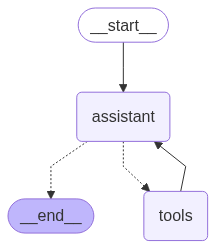

In [37]:
# Create the state graph for the conversation flow
builder = StateGraph(MessagesState)

#Add nodes and edges to the graph
builder.add_node("assistant",assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge(START, "assistant")
builder.add_edge("tools","assistant")

react_graph = builder.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))



In [ ]:
#Choose one of the accounts printed above
messages = [HumanMessage(content="What is the current status of my loan? My account ID is ACC513215.")]
result = react_graph.invoke({"messages": messages})
for m in result["messages"]:
    m.pretty_print()
print("==========================")
print_key_trace(result)


================================ Human Message =================================

What is the current status of my loan? My account ID is ACC513215.
================================== Ai Message ==================================

[{'type': 'text', 'text': "I'll help you check the status of your loan by using the get_loan_status function with your provided account ID."}, {'type': 'tool_use', 'name': 'get_loan_status', 'input': {'account_id': 'ACC513215'}, 'id': 'tooluse_MvX8Pp1WQiqJDXbp1XWkcw'}]
Tool Calls:
  get_loan_status (tooluse_MvX8Pp1WQiqJDXbp1XWkcw)
 Call ID: tooluse_MvX8Pp1WQiqJDXbp1XWkcw
  Args:
    account_id: ACC513215
================================= Tool Message =================================
Name: get_loan_status

[{"id": 301, "account_id": "ACC513215", "loan_amount": 35143.22, "interest_rate": 7.03, "status": "pending", "last_updated": "2024-12-26 12:01:01"}]
================================== Ai Message ==================================

Based on the loan status i

In [41]:
messages = [HumanMessage(content="Should I invest in stocks for my retirement?")]
result = react_graph.invoke({"messages": messages})
print(result)
for m in result["messages"]:
    m.pretty_print()
print("==========================")
print_key_trace(result)

{'messages': [HumanMessage(content='Should I invest in stocks for my retirement?', additional_kwargs={}, response_metadata={}, id='274a200e-ebe8-4a84-b1f2-c1bbfa722b61'), AIMessage(content='Sorry, contact our customer service for this request. ', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'da95e0ed-42ea-4fc9-b036-dc482c779db8', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 24 Jun 2025 11:03:15 GMT', 'content-type': 'application/json', 'content-length': '778', 'connection': 'keep-alive', 'x-amzn-requestid': 'da95e0ed-42ea-4fc9-b036-dc482c779db8'}, 'RetryAttempts': 0}, 'stopReason': 'guardrail_intervened', 'metrics': {'latencyMs': [289]}, 'trace': {'guardrail': {'inputAssessment': {'pg7497emjzyx': {'topicPolicy': {'topics': [{'name': 'Fiduciary Advice', 'type': 'DENY', 'action': 'BLOCKED'}]}, 'invocationMetrics': {'guardrailProcessingLatency': 230, 'usage': {'topicPolicyUnits': 1, 'contentPolicyUnits': 1, 'wordPolicyUnits': 1, 'sensitiveInformationP

## 4.2 Create the agent and use Apply Guardrail API
We will now apply the gaurdrail using the Apply Guardrail API. 



In [21]:
# Function to apply Bedrock Guardrails to content directly
def apply_guardrails(content: str) -> Tuple[str, Dict]:
    """Apply AWS Bedrock Guardrails to content"""
    try:
        print(f"Applying guardrail to content: {content[:50]}...")
        response = bedrock_client.apply_guardrail(
            guardrailIdentifier=guardrail_id,
            guardrailVersion="DRAFT",
            source="INPUT",
            content=[
                {
                    "text": {
                        "text": content
                    }
                }
            ]
        )
        
        print(f"Guardrail response: {json.dumps(response, indent=2)[:200]}...")
        # Parse response
        outputs = response.get('outputs', [])
        if outputs and len(outputs) > 0:
            guardrailed_content = outputs[0].get('text', {}).get('text', content)
        else:
            guardrailed_content = content
        
        # Create metadata dictionary
        metadata = {
            "action": response.get('action', 'NONE'),
            "assessments": response.get('assessments', [])
        }
        
        return guardrailed_content, metadata
    
    except Exception as e:
        print(f"Error applying guardrails: {e}")
        return content, {}

In [18]:
llm = ChatBedrockConverse(
    model="us.anthropic.claude-3-5-haiku-20241022-v1:0",
    client=bedrock_client,
    temperature=0.7,

)
llm_with_tools = llm.bind_tools(tools)

def assistant(state: MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_message] + state["messages"])]}

In [19]:

builder = StateGraph(MessagesState)

builder.add_node("assistant",assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge(START, "assistant")
builder.add_edge("tools","assistant")

react_graph = builder.compile()


We will apply guardrails to the input (i.e the user query), however the same can be done for the output (i.e the model response) as well. The Apply Guardrail API will return a modified input and output if the guardrail is triggere

In [22]:
messages = [HumanMessage(content="What is the current status of my loan? My account ID is ACC612330.")]
guardrailed_input, metadata = apply_guardrails(messages[0].content)
print(metadata)
if metadata['action'] == "GUARDRAIL_INTERVENED":
    print("Guardrail intervention detected! ")
else:   
    result = react_graph.invoke({"messages": guardrailed_input})
    for m in result["messages"]:
        m.pretty_print()
        print("==========================")
        print_key_trace(result)


Applying guardrail to content: What is the current status of my loan? My account ...
Error applying guardrails: 'Bedrock' object has no attribute 'apply_guardrail'
{}


KeyError: 'action'

In [115]:
messages = [HumanMessage(content="Should I invest in bitcoin?.")]
guardrailed_input, metadata = apply_guardrails(messages[0].content)
print(metadata)
if metadata['action'] == "GUARDRAIL_INTERVENED":
    print("Guardrail intervention detected! ")
else:   
    result = react_graph.invoke({"messages": guardrailed_input})
    for m in result["messages"]:
        m.pretty_print()
        print("==========================")
        print_key_trace(result)

Applying guardrail to content: Should I invest in bitcoin?....
Guardrail response: {
  "ResponseMetadata": {
    "RequestId": "a3438dd2-6cdc-4ede-a156-5148c8e808a3",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Thu, 12 Jun 2025 17:06:35 GMT",
      "content-type": ...
{'action': 'NONE', 'assessments': [{'invocationMetrics': {'guardrailProcessingLatency': 219, 'usage': {'topicPolicyUnits': 1, 'contentPolicyUnits': 1, 'wordPolicyUnits': 1, 'sensitiveInformationPolicyUnits': 1, 'sensitiveInformationPolicyFreeUnits': 0, 'contextualGroundingPolicyUnits': 0}, 'guardrailCoverage': {'textCharacters': {'guarded': 28, 'total': 28}}}}]}
================================ Human Message =================================

Should I invest in bitcoin?.
Key Guardrail Trace:
{}
================================== Ai Message ==================================

I apologize, but I cannot provide investment advice or recommendations about specific investments like Bitcoin. Making investment d